# MODIS Water XGBOOST 

Version: 0.1.0

Date modified: 02.08.2022

Modified by: Caleb Spradlin

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, recall_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

sys.path.append('../scripts/')
import notebook_util as nu

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [90]:
FIGURE_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output'
RASTER_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output'
MODEL_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/models/'

GPU = True
TILE = 'global'
MODEL = 'xgboost_imbalanced_land_0.50_nontuned'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
colsToDrop = ['x_offset', 'y_offset']
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [3]:
if GPU:
    nu.setup_one_gpu() # Choose the GPU with the lowest memory usage

Picking GPU 0


In [4]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [5]:
glob_string = '/att/nobackup/cssprad1/projects/modis_water/data/training_data/v1.1.0/MOD09_{}_*.parquet.gzip'.format(TILE)
data_paths = [fv for fv in glob.glob(glob_string)]
data_path = data_paths[0]
pprint(data_paths)

['/att/nobackup/cssprad1/projects/modis_water/data/training_data/v1.1.0/MOD09_global_WATER_TR_DATA_#5516128.parquet.gzip']


In [70]:
X_train, X_test, y_train, y_test = load_data(fpath=data_path,
                                             colsToDrop=colsToDrop,
                                             dataType=DATA_TYPE,
                                             cpu=True,
                                             splitXY=True,
                                             imbalance=True,
                                             land=True,
                                             frac=0.50,
                                             trainTestSplit=True,
                                             multi=False)

In [71]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [72]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,3349693.0,534.312804,605.509197,-100.0,140.0,405.0,710.0,16000.0
sur_refl_b02_1,3349693.0,1844.288966,1426.755896,-100.0,155.0,2074.0,2903.0,16000.0
sur_refl_b03_1,3349693.0,331.731600,409.717006,-100.0,155.0,244.0,394.0,15361.0
sur_refl_b04_1,3349693.0,550.509186,492.633993,-100.0,256.0,502.0,707.0,16000.0
sur_refl_b05_1,3349693.0,2011.735930,1485.076640,-100.0,173.0,2436.0,3210.0,16000.0
sur_refl_b06_1,3349693.0,1496.879778,1135.783837,-100.0,242.0,1605.0,2287.0,14957.0
sur_refl_b07_1,3349693.0,816.897898,808.744050,-100.0,125.0,655.0,1142.0,11879.0
ndvi,3349693.0,2240.212821,7347.829830,-32762.0,-80.0,4723.0,7236.0,32762.0
ndwi1,3349693.0,-1509.279284,5946.152057,-32759.0,-2314.0,133.0,2411.0,32767.0
ndwi2,3349693.0,1199.970970,7537.145386,-32759.0,-602.0,3366.0,6121.0,32767.0


In [73]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [74]:
output_interesting_idx(X_train, 'ndvi', 10000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
260369,5,-28,196,209,5,314,272,14347,-11958,-12295
3433445,14,-30,171,137,-88,49,17,27500,23958,-29383
825868,21,-13,228,125,-6,54,27,23036,-16341,-28571
3407941,13,-7,84,75,17,63,30,32203,-12500,-16086
2965132,12,-7,307,94,30,42,46,27536,-14000,-13589
...,...,...,...,...,...,...,...,...,...,...
587143,-100,643,-100,-100,1884,2364,2020,13683,-5723,-5170
140779,58,-35,141,133,63,109,145,25102,-19459,-16363
1704123,1,-4,197,55,4,31,38,16666,-12962,-12352
3056613,-26,1066,-100,-100,1886,2130,1703,10500,-3329,-2300


In [75]:
output_interesting_idx(X_train, 'ndwi1', 10000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
3433445,14,-30,171,137,-88,49,17,27500,23958,-29383
1471110,-87,-100,-50,44,-21,79,46,695,19702,27037
395936,-26,-39,116,69,-2,73,23,2000,32595,-26786
220907,14,-35,233,100,-38,7,9,23333,15000,16923
3412474,25,-20,169,141,-4,24,8,-24464,21072,23333
...,...,...,...,...,...,...,...,...,...,...
2804510,18,-8,186,113,17,13,-3,-26000,23536,4545
989665,-44,-34,94,43,-51,57,21,-1282,25971,-23229
2033797,75,-43,52,424,-56,68,22,28661,21136,30952
167416,29,-39,348,391,34,47,-1,2464,23572,9500


In [76]:
output_interesting_idx(X_train, 'ndwi2', 10000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
770696,44,-10,36,126,-4,44,15,-15882,-15882,15536
1471110,-87,-100,-50,44,-21,79,46,695,19702,27037
3775102,-31,-6,84,-1,-13,68,11,-6756,-11935,31536
513354,337,173,306,507,80,98,-7,-3215,2767,10843
2565099,-100,-100,3867,1915,-100,62,8,0,-22905,11739
...,...,...,...,...,...,...,...,...,...,...
1693645,50,2,83,79,14,21,-3,-9230,-8260,15536
146311,53,-2,364,241,33,53,3,-10784,-10784,15536
1137789,-77,-10,-100,-100,-44,52,5,-7701,-14761,30000
1179683,-27,-94,148,234,-11,76,17,5537,28908,14415


## XGBOOST

In [77]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [78]:
hyperparameters = {'objective': 'binary:logistic',
                   'n_estimators':200,
                   'base_score': None,
                   'booster': None,
                   'colsample_bylevel': None,
                   'colsample_bynode': None,
                   'colsample_bytree': None,
                   'gamma': None,
                   'gpu_id': None,
                   'interaction_constraints': None,
                   'learning_rate': 0.003,
                   'max_delta_step': None,
                   'max_depth': None,
                   'min_child_weight': None,
                   'monotone_constraints': None,
                   'n_jobs': None,
                   'num_parallel_tree': None,
                   'random_state': None,
                   'reg_alpha': None,
                   'reg_lambda': None,
                   'scale_pos_weight': None,
                   'subsample': None,
                   'tree_method': None,
                   'validate_parameters': None,
                   'verbosity': None}

In [79]:
classifier = xgb.XGBClassifier(**hyperparameters)

In [80]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["error","auc"]

In [81]:
classifier.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=10)

[0]	validation_0-error:0.04777	validation_0-auc:0.97922	validation_1-error:0.04736	validation_1-auc:0.97925
[1]	validation_0-error:0.04777	validation_0-auc:0.97928	validation_1-error:0.04736	validation_1-auc:0.97930
[2]	validation_0-error:0.04774	validation_0-auc:0.97934	validation_1-error:0.04732	validation_1-auc:0.97935
[3]	validation_0-error:0.04774	validation_0-auc:0.97935	validation_1-error:0.04732	validation_1-auc:0.97935
[4]	validation_0-error:0.04774	validation_0-auc:0.97935	validation_1-error:0.04732	validation_1-auc:0.97935
[5]	validation_0-error:0.04773	validation_0-auc:0.97941	validation_1-error:0.04731	validation_1-auc:0.97943
[6]	validation_0-error:0.04773	validation_0-auc:0.97941	validation_1-error:0.04731	validation_1-auc:0.97943
[7]	validation_0-error:0.04772	validation_0-auc:0.97941	validation_1-error:0.04730	validation_1-auc:0.97944
[8]	validation_0-error:0.04773	validation_0-auc:0.97945	validation_1-error:0.04729	validation_1-auc:0.97947
[9]	validation_0-error:0.047

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.003, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=40, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

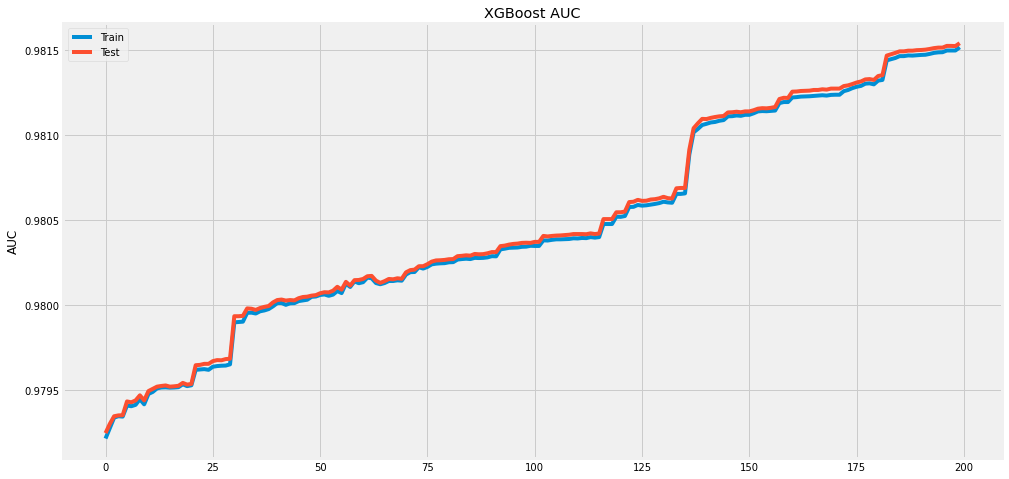

In [82]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

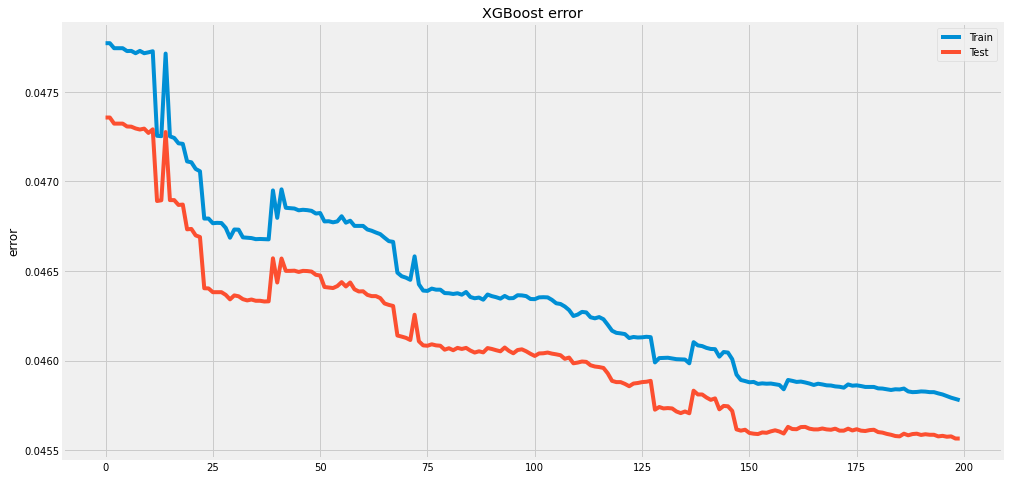

In [83]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('error')
plt.title('XGBoost error')
plt.show()

## Model testing and training/testing data validation

### Get model metrics

In [84]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.954

In [85]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [86]:
predictionProbabilityList = list()
for i, subarr in enumerate(prediction_probs):
    predictionProbabilityList.append(subarr[1])
predictionProbabilityArray = np.asarray(predictionProbabilityList)

Text(0.5, 1.0, 'Distribution of the probability of predicted values')

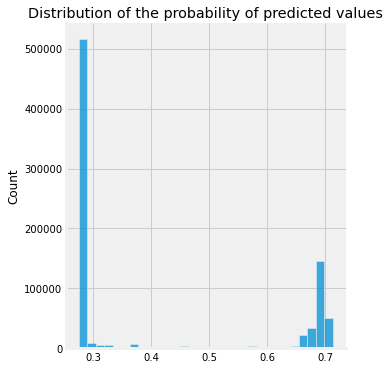

In [87]:
sns.displot(predictionProbabilityArray, bins=30)
plt.title('Distribution of the probability of predicted values')

In [88]:
test_predictions = test_predictions.astype(np.int32)
y_test_int = y_test.astype(np.int32)

In [89]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    579507
           1       0.91      0.95      0.93    257917

    accuracy                           0.95    837424
   macro avg       0.94      0.95      0.95    837424
weighted avg       0.96      0.95      0.95    837424

Test Recall
-------------------------------------------------------
0.9556019168016953
Confusion Matrix
-------------------------------------------------------
[[553778  25729]
 [ 12428 245489]]


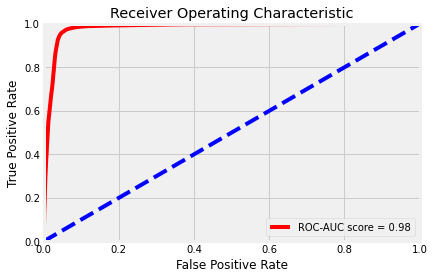

In [91]:
probs = classifier.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC-AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Permutation importance

In [28]:
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

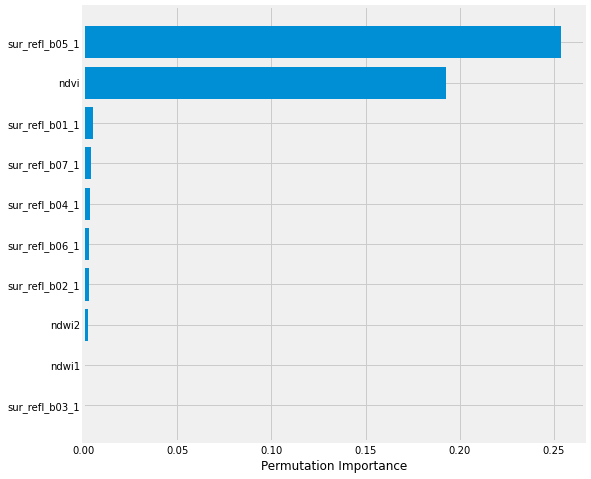

In [29]:
png_save_path = 'mw_all_{}_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    score,
    hyperparameters['n_estimators'],
    MODEL,
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig(png_save_path)

In [93]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## Save the model for future use

In [92]:
model_save_path = 'mw_all_{}_{}_{}_{}_tuned_{}.sav'.format(TILE,
                                                              score,
                                                              hyperparameters['n_estimators'],
                                                              MODEL,
                                                              'gpu' if GPU else 'cpu',
                                                              datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))
model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: /att/nobackup/cssprad1/projects/modis_water/models/mw_all_global_0.954_200_xgboost_imbalanced_land_0.50_nontuned_tuned_gpu.sav
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.003, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=40, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


['mw_all_global_0.954_200_xgboost_imbalanced_land_0.50_nontuned_tuned_gpu.sav']

# Testing: Raster testing

In [94]:
TILE = 'h12v09'

In [95]:
DAY = 218
YEAR = 2006
PATH = '/att/nobackup/cssprad1/projects/modis_water/data/test_data/{}/'.format(TILE)

In [96]:
vars_list = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list.sort()
vars_list

['/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b01_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b02_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b03_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b04_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b05_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b06_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b07_1.tif']

## Get dimensions of inputs

In [97]:
vrt_opts = gdal.BuildVRTOptions(separate=True)
dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_opts)
nrows, ncols = dd.RasterYSize, dd.RasterXSize
dd = None
if os.path.exists('tmp.vrt'):
    os.remove('tmp.vrt') 
nrows, ncols

(4800, 4800)

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [98]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [99]:
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[6643 7273 6168 ...  452  962 3003]
 [6643 7273 6168 ...  452  962 3003]
 [6172 6885 5686 ...  546  881 2691]
 ...
 [ 419 2432  206 ... 7060 1580 5026]
 [ 751 2327  316 ... 5120 -404 2895]
 [ 751 2327  316 ... 5120 -404 2895]]
460.8 MB size


In [100]:
def predictRaster(img_chunk):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, dtype=np.int16)
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [101]:
predictedRaster, predictedProbaRaster, df = predictRaster(im)

Making predictions from raster


In [102]:
shp = (4800, 4800)
left = list()
right = list()
for i, subarr in enumerate(predictedProbaRaster):
    left.append(subarr[0])
    right.append(subarr[1])
leftArr = np.asarray(left)
rightArr = np.asarray(right)
probaLand = leftArr.reshape(shp)
probaWater = rightArr.reshape(shp)

## Inputreshapet raster: description and histogram

In [103]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,23040000.0,406.319013,434.922643,-28672.0,250.0,306.0,360.0,9953.0
1,23040000.0,3162.238815,649.746304,-28672.0,2923.0,3309.0,3518.0,9242.0
2,23040000.0,291.899561,406.622174,-28672.0,166.0,212.0,269.0,9013.0
3,23040000.0,557.999866,406.551242,-28672.0,421.0,493.0,546.0,9716.0
4,23040000.0,3133.262860,632.134972,-28672.0,2923.0,3264.0,3468.0,9040.0
5,23040000.0,1720.846256,526.672817,-28672.0,1506.0,1710.0,1812.0,7103.0
6,23040000.0,530.845410,1843.350129,-28672.0,480.0,547.0,610.0,6316.0
7,23040000.0,7686.235761,2031.676702,-32222.0,7954.0,8349.0,8546.0,32203.0
8,23040000.0,2985.519139,1161.269606,-32727.0,2979.0,3300.0,3518.0,32620.0
9,23040000.0,6634.247958,1770.533043,-32727.0,6823.0,7209.0,7398.0,32679.0


Text(0.5, 1.0, 'Distribution of each band and calculated idx')

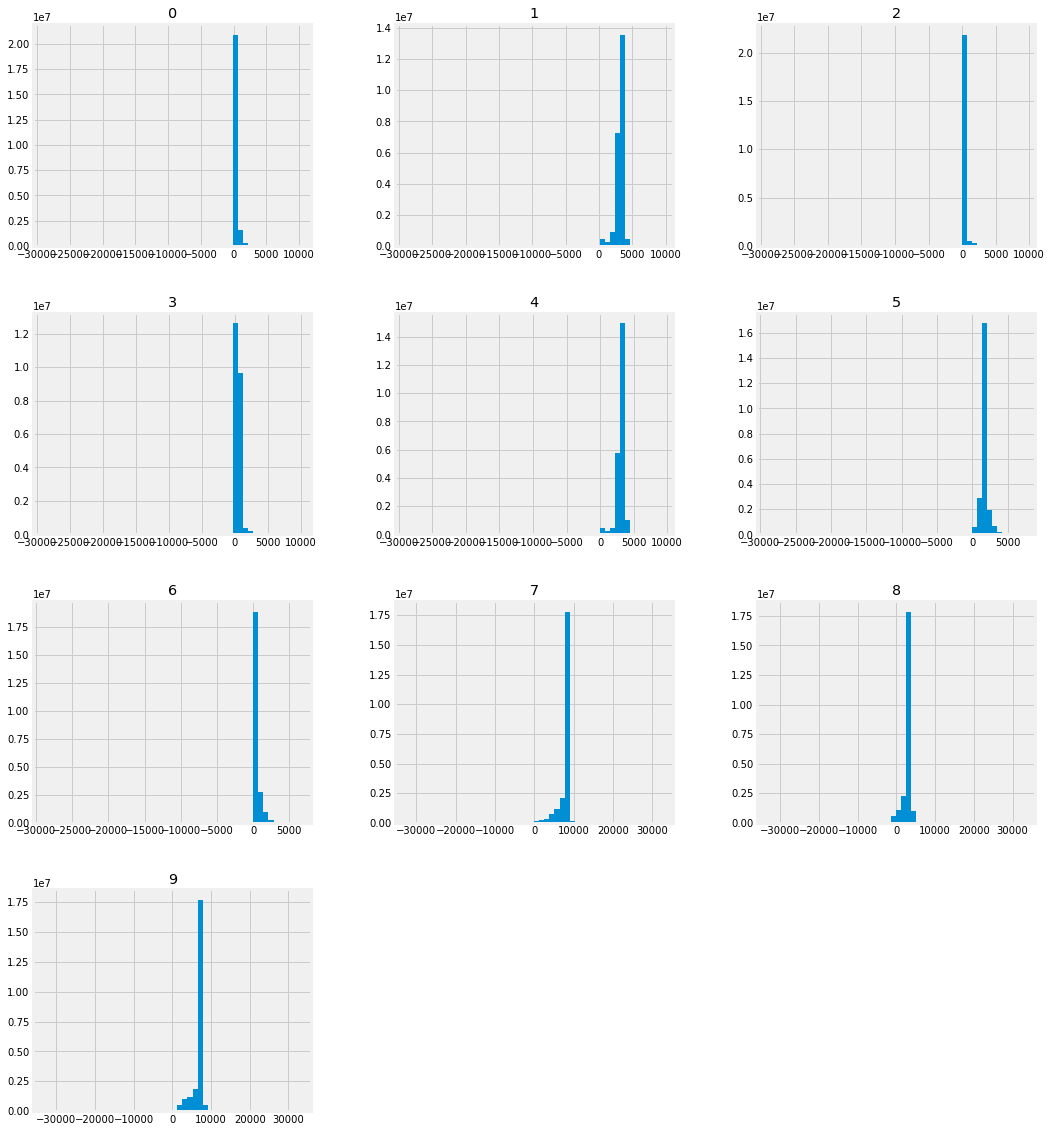

In [104]:
df.hist(figsize=(16, 20), bins=50)
plt.title('Distribution of each band and calculated idx')

#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [105]:
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(4800, 4800)

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [106]:
qaMask = '/att/nobackup/cssprad1/projects/modis_water/data/qa_masks'
waterMask = '/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019'
qa_list = [fn for fn in glob.glob(os.path.join(qaMask, '*A{}{:03}.{}*bad_good_mask.tif'.format(YEAR, DAY, TILE)))]
water_list = [fn for fn in glob.glob(os.path.join(waterMask, '*{}*.tif'.format(TILE)))]
qa_mask = qa_list[0]
water_mask = water_list[0]
print(water_mask)
print(qa_mask)
ds = gdal.Open(qa_mask, gdal.GA_ReadOnly)
waterMask = gdal.Open(water_mask, gdal.GA_ReadOnly)
qaMaskMatrix = ds.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMaskMatrix = waterMask.GetRasterBand(1).ReadAsArray().astype(np.int16)
ds = None
waterMask = None

/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019/MOD44W_h12v09_min2000_2019.tif
/att/nobackup/cssprad1/projects/modis_water/data/qa_masks/MOD09GA.A2006218.h12v09.061.2020268185436_bad_good_mask.tif


In [107]:
waterMaskMatrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

### Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad"

In [108]:
maskedResult = np.where(qaMaskMatrix == 0, reshp, -9999)
maskedResultProba = np.where(qaMaskMatrix == 0, probaWater, -9999)
waterMasked = np.where(qaMaskMatrix == 0, waterMaskMatrix, -9999)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

# Generating stats for predicted and truth

## Predicted Raster

In [109]:
TILE = 'global_{}_{}'.format(MODEL, TILE)

Text(0.5, 1.0, 'Predicted water mask')

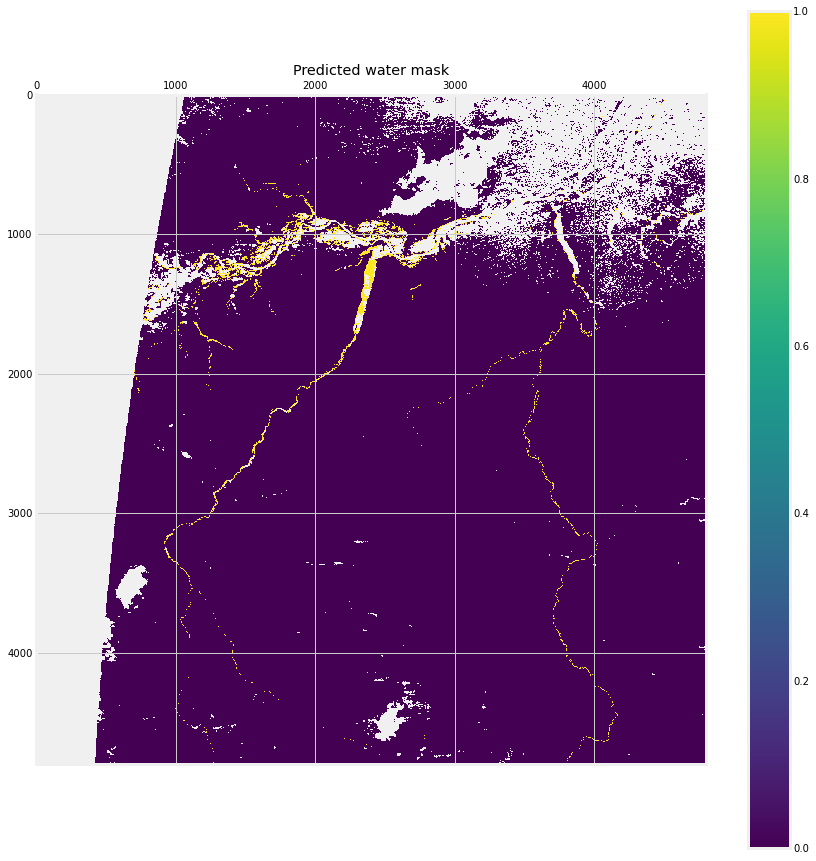

In [110]:
plt.figure(figsize=(15, 15))
outputPlt = plt.matshow(np.where(maskedResult == -9999, np.NaN, maskedResult), fignum=1)
plt.colorbar()
plt.title('Predicted water mask')

## Predicted Probabilities

Text(0.5, 1.0, 'Predicted probabilities of water')

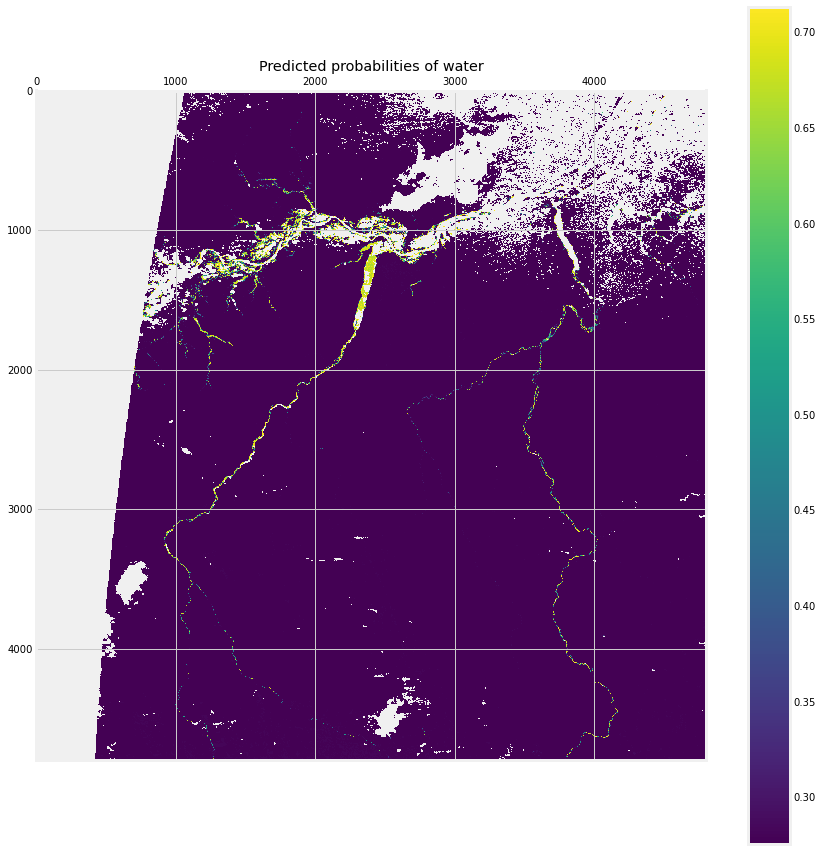

In [111]:
plt.figure(figsize=(15, 15))
outputPlt = plt.matshow(np.where(maskedResult == -9999, np.NaN, maskedResultProba), fignum=1)
plt.colorbar()
plt.title('Predicted probabilities of water')

## Minimum Extent Water Mask

Text(0.5, 1.0, 'Minimum extent water mask')

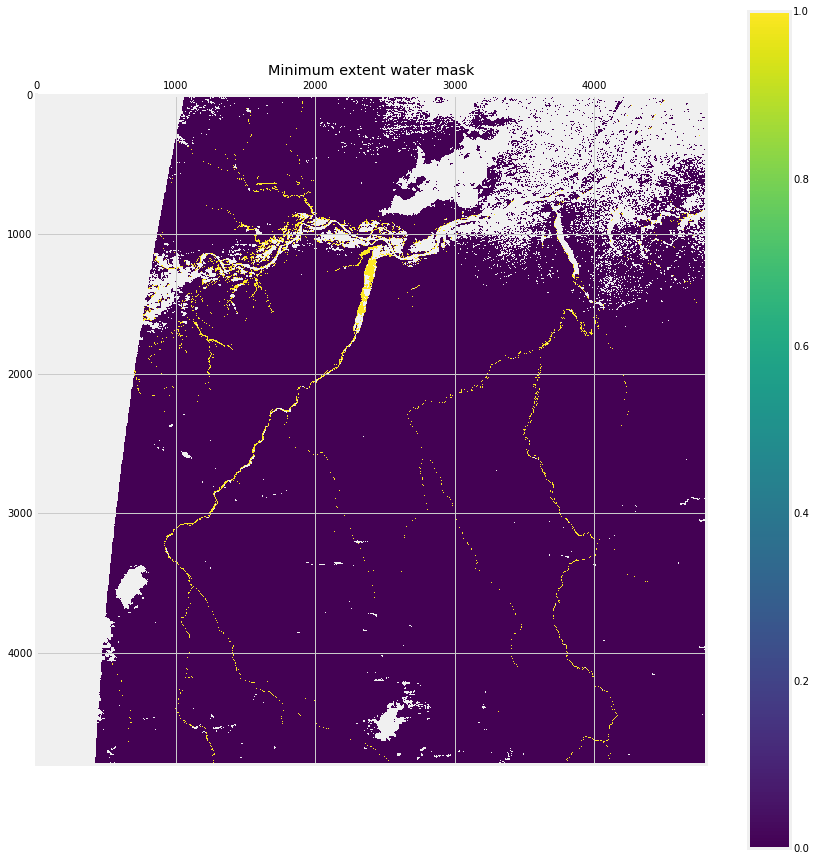

In [112]:
plt.figure(figsize=(15, 15))
truth = np.where(waterMasked==-9999, np.NaN, waterMasked)
truth = np.where(waterMasked==250, np.NaN, truth)
truthPlt = plt.matshow(truth, fignum=1)
plt.colorbar()
plt.title('Minimum extent water mask')

## Metrics on test raster

In [113]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))

### Count num of occurences for each class with the masked predicted result

In [114]:
countNoData = np.count_nonzero(maskedResult == -9999)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 Nodata occurences: 5364592
 Land occurance: 17472740
 Water occurances: 202668


### Count num of occurences for each class with the water mask

In [115]:
countNoDataT = np.count_nonzero(waterMasked == -9999)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

Truth Vals
 Nodata occurences: 5364592
 Land occurance: 17468360
 Water occurances: 207048


### Model metrics on raster data

In [116]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))

Metrics of Accuracy for Raster Test Data
True Positives:  141953
True Negatives:  17407645
False Positives: 60715
False Negatives: 65095
Total "good" data: 17675408
Accuracy*: 0.9928822010784701
Precision: 0.7004213788067184
Recall: 0.6856043043159075
f1: 0.6929336418397134


## Output predicted raster to GeoTiff

In [117]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output probabilies raster masked by good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPathProba, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResultProba)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/2006_218_global_xgboost_imbalanced_land_0.50_nontuned_h12v09_predicted_xgboost_imbalanced_land_0.50_nontuned.tif
/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/waterMask_2006_qa_218.tif
/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/2006_218_global_xgboost_imbalanced_land_0.50_nontuned_h12v09_predicted_probabilities_xgboost_imbalanced_land_0.50_nontuned.tif
Transform
(-6671703.118, 231.656358, 0.0, 0.0, 0.0, -231.656358)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["me